# Graph'ın Çizimi

In [32]:
import matplotlib.pyplot as plt  # Grafik çizimlerini yapmak için matplotlib kütüphanesi
import networkx as nx  # Ağ grafikleri oluşturmak için NetworkX kütüphanesi
import pandas as pd  # Veri analizi ve tablo işlemleri için pandas kütüphanesi
import numpy as np  # Sayısal işlemler için numpy kütüphanesi

def get_graph_from_user():
    """Kullanıcıdan kenar bilgilerini alarak grafiği oluşturur."""
    G = nx.MultiDiGraph()  # Çoklu yönlü graf oluşturuyoruz (aynı kenarın birden fazla yönü olabilir)

    # Kullanıcıdan kenarları almak için bir döngü başlatıyoruz
    print("Kenarlar için kaynak, hedef ve ağırlık bilgilerini girin (örneğin: A B 3). Çıkmak için 'q' yazın.")
    while True:
        # Kullanıcıdan kenar girişi alıyoruz
        edge_input = input("Kenar (Kaynak Hedef Ağırlık): ")
        # Kullanıcı çıkmak isterse 'q' girer
        if edge_input.lower() == 'q':
            break  # Döngüyü bozarak kullanıcıdan kenar girişi alınmasını sonlandırıyoruz

        edge_info = edge_input.split()  # Girilen kenar bilgisini boşluklardan ayırıyoruz
        if len(edge_info) == 3:  # Girilen verinin üç bileşenden oluştuğuna emin oluyoruz
            source, target, weight = edge_info  # Kaynak, hedef ve ağırlık bilgilerini değişkenlere atıyoruz
            try:
                weight = int(weight)  # Ağırlığı tamsayıya dönüştürüyoruz
                # Grafiğe kenar ekliyoruz
                G.add_edge(source, target, weight=weight)
            except ValueError:
                print("Ağırlık geçerli bir sayı olmalı!")  # Ağırlık geçerli bir sayı değilse hata mesajı
        else:
            print("Geçerli bir kenar formatı girin: Kaynak Hedef Ağırlık")  # Kullanıcı yanlış formatta veri girerse uyarı

    return G  # Kullanıcının oluşturduğu grafiği geri döndürüyoruz

def plot_graph(G):
    """Grafiği çizdirir."""
    pos = nx.spring_layout(G)  # Düğümleri 'spring_layout' algoritması ile yerleştiriyoruz
    plt.figure(figsize=(8, 8))  # Grafik boyutunu belirliyoruz

    # Düğümleri çizdiriyoruz, düğüm boyutunu ve renklerini belirliyoruz
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color="cyan", edgecolors="black")

    # Kenarları çiziyoruz ve yaylarla ayrıştırma (arc3, rad) kullanarak yönlü kenarları oklarla belirliyoruz
    for (u, v, d) in G.edges(data=True):  # Kenarları ve ağırlıkları alıyoruz
        rad = 0.2 if (v, u) in G.edges else 0  # Yönlü kenarlar için yaylama efekti
        # Kenarları çiziyoruz
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v)],  # Sadece mevcut kenarı çiziyoruz
            connectionstyle=f"arc3,rad={rad}",  # Yayla etkisi ekliyoruz
            edge_color="black",  # Kenar rengini siyah yapıyoruz
            arrowstyle="->",  # Yönlü ok ekliyoruz
            arrowsize=15,  # Ok boyutunu belirliyoruz
            width=2,  # Kenar kalınlığını ayarlıyoruz
        )

    # Kenar ağırlıklarını yerleştiriyoruz
    edge_labels = {}  # Kenar etiketlerini depolamak için bir sözlük oluşturuyoruz
    for (u, v, d) in G.edges(data=True):
        rad = 0.2 if (v, u) in G.edges else 0  # Yönlü kenarlar için yaylama efekti
        # Kenarın orta noktasını hesaplıyoruz
        edge_midpoint = ((pos[u][0] + pos[v][0]) / 2, (pos[u][1] + pos[v][1]) / 2)
        offset = rad * 0.5  # Yönlü kenarların biraz daha uzak görünmesini sağlıyoruz
        label_pos = (edge_midpoint[0] - offset, edge_midpoint[1] + offset)  # Etiketin konumunu hesaplıyoruz
        edge_labels[(u, v)] = f"{d['weight']}"  # Kenar ağırlığını etiket olarak belirliyoruz

    # Kenar ağırlıklarını grafik üzerine ekliyoruz
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_color="blue", font_size=10, label_pos=0.75
    )

    # Düğümleri etiketliyoruz
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black", font_weight="bold")

    # Eksenleri kapatıp, başlık ekliyoruz
    plt.title("Çift Yönlü Kenarlarla Doğru Ağırlık Etiketleri", fontsize=14)
    plt.axis("off")  # Eksenleri kapatıyoruz
    plt.show()  # Grafiği ekranda gösteriyoruz

def generate_edge_table(G):
    """Grafikten kenarları içeren tabloyu döndürür."""
    edge_data = []  # Kenar verilerini tutacak listeyi oluşturuyoruz
    for u, v, d in G.edges(data=True):  # Kenarları ve ağırlıkları alıyoruz
        edge_data.append([u, v, d['weight']])  # Kenar bilgilerini listeye ekliyoruz

    # Kenar verilerini pandas DataFrame'e dönüştürüyoruz
    edge_df = pd.DataFrame(edge_data, columns=['Kaynak', 'Hedef', 'Ağırlık'])
    return edge_df  # Kenar tablosunu döndürüyoruz


# Floyd-Warshall Algoritması

In [33]:
import networkx as nx
import numpy as np

# Floyd-Warshall algoritmasını çalıştıran fonksiyon
def floyd_warshall(edges):
    """
    Floyd-Warshall algoritmasını çalıştırarak verilen kenarlarla en kısa yolları hesaplar.
    Parametre:
        edges: (kaynak, hedef, ağırlık) formatında kenar bilgileri listesi.
    """
    # MultiDiGraph oluştur ve kenarları tanımla
    G = nx.MultiDiGraph()  # Çoklu yönlü bir grafik oluşturuyoruz (aynı kenar birden fazla olabilir)

    # Kenarları grafiğe ekliyoruz
    G.add_weighted_edges_from(edges)  # Kullanıcıdan alınan kenar bilgilerini grafiğe ekliyoruz

    # Düğümleri sıralıyoruz (alfabetik sıraya göre)
    nodes = sorted(G.nodes())  # Düğümleri sıralıyoruz

    # Düğüm sayısını hesaplıyoruz
    N = len(nodes)  # Toplam düğüm sayısını alıyoruz

    # İndeksleme için düğümlerin sırasını dictionary'e çeviriyoruz
    node_index = {node: i for i, node in enumerate(nodes)}  # Düğüm adı -> indeks eşlemesi yapıyoruz


    inf = float('inf')  # Sonsuz değeri için 'inf' kullanıyoruz

    # Floyd-Warshall algoritması için yol ve mesafe matrislerini başlatıyoruz
    yol = np.full((N, N), inf)  # Yol matrisi, başlangıçta tüm yollar sonsuz
    mesafe = np.full((N, N), inf)  # Mesafe matrisi, başlangıçta tüm mesafeler sonsuz

    # Başlangıçta, kendi kendine mesafe sıfırdır
    for i in range(N):
        mesafe[i, i] = 0  # Bir düğümün kendisine olan mesafesi her zaman sıfırdır

    # Başlangıçta, her kenarın ağırlıklarına göre mesafe matrisini güncelliyoruz
    for u, v, data in G.edges(data=True):  # Tüm kenarları dolaşıyoruz
        i, j = node_index[u], node_index[v]  # Kaynak ve hedef düğümün indekslerini alıyoruz
        mesafe[i, j] = data['weight']  # Mesafeyi kenarın ağırlığına eşitliyoruz
        yol[i, j] = i  # Başlangıç yol matrisi: Uç nokta i

    # Floyd-Warshall algoritmasını çalıştırıyoruz
    for k in range(N):
        """
        Burada k, ara düğümdür. K, tüm düğümleri kontrol ederek en kısa yolları hesaplamak için kullanılır.
        k = 1'den N'e kadar tüm düğümleri değerlendiriyoruz.
        """

        # Adım k'yı ekranda görmek için matrisleri yazdırıyoruz
        print(f"\nAdım {k+1} (k={k}):")
        print(f"{'':<3}", end="")  # Başlangıç boşluk ekliyoruz
        for node in nodes:  # Düğümleri yazdırıyoruz
            print(f"{node:<5}", end="")
        print()

        # Mesafe matrisini ekranda yazdırıyoruz
        for i, row in enumerate(mesafe):
            print(f"{nodes[i]:<3}", end="")  # Satır başındaki düğümü yazdırıyoruz
            for val in row:  # Satırdaki her mesafe değerini yazdırıyoruz
                if val == float('inf'):  # Sonsuz mesafeyi 'inf' olarak yazdırıyoruz
                    print("inf ", end="")
                else:
                    print(f"{val:<5}", end="")  # Diğer mesafeleri düzgün formatta yazdırıyoruz
            print()

        print("---------------------------------------")

        # Floyd-Warshall algoritmasını uygulamaya devam ediyoruz
        # Bu kısımda, mesafe[i, j] yolunun k düğümü geçip geçmediğine bakılıyor
        for i in range(N):  # Tüm kaynak düğümleri üzerinden geçiyoruz
            for j in range(N):  # Tüm hedef düğümleri üzerinden geçiyoruz
                # Eğer mevcut mesafe, k üzerinden geçen mesafeden daha büyükse, güncelliyoruz
                if mesafe[i, j] > mesafe[i, k] + mesafe[k, j]:
                    mesafe[i, j] = mesafe[i, k] + mesafe[k, j]  # Mesafeyi güncelliyoruz
                    yol[i, j] = yol[k, j]  # En kısa yolu güncelliyoruz

    # Sonuçları ekranda yazdırıyoruz
    print("\nSonuç Mesafe Matrisi:")
    print(f"{'':<3}", end="")  # Başlık için boşluk bırakıyoruz
    for node in nodes:  # Düğümleri yazdırıyoruz
        print(f"{node:<5}", end="")
    print()

    # Mesafe matrisini yazdırıyoruz
    for i, row in enumerate(mesafe):
        print(f"{nodes[i]:<3}", end="")  # Satır başındaki düğümü yazdırıyoruz
        for val in row:  # Her mesafe değerini yazdırıyoruz
            if val == float('inf'):  # Sonsuz mesafeyi 'inf' olarak yazdırıyoruz
                print("inf ", end="")
            else:
                print(f"{val:<5}", end="")  # Diğer mesafeleri düzgün formatta yazdırıyoruz
        print()

# Kullanıcıdan kenarları alacak fonksiyon
def get_edges_from_user():
    """
    Kullanıcıdan kenar bilgilerini alır ve uygun formatta bir liste döndürür.
    Kullanıcı "Q" tuşuna basana kadar kenarları almaya devam eder.
    """
    edges = []  # Kenarları tutacak bir liste başlatıyoruz
    print("Kenarları girin (örnek: 'A B 3' veya 'Q' ile sonlandırın):")
    while True:
        # Kullanıcıdan kenar bilgisi alıyoruz
        edge_input = input("Kenar (kaynak hedef ağırlık): ").strip()
        if edge_input.lower() == 'Q':  # Kullanıcı 'Q' girerse döngü durur
            break
        try:
            u, v, weight = edge_input.split()  # Kaynak, hedef ve ağırlığı ayırıyoruz
            weight = float(weight)  # Ağırlığı float türüne dönüştürüyoruz
            edges.append((u, v, weight))  # Kenarı listeye ekliyoruz
        except ValueError:
            print("Geçersiz giriş, lütfen doğru formatta girin (örn: 'A B 3')")  # Hatalı girişleri uyarıyoruz
    return edges  # Kullanıcının girdiği kenarları döndürüyoruz


# Main

Kenarlar için kaynak, hedef ve ağırlık bilgilerini girin (örneğin: A B 3). Çıkmak için 'q' yazın.
Kenar (Kaynak Hedef Ağırlık): A B 3
Kenar (Kaynak Hedef Ağırlık): B A 8
Kenar (Kaynak Hedef Ağırlık): A D 7
Kenar (Kaynak Hedef Ağırlık): D A 2
Kenar (Kaynak Hedef Ağırlık): B C 2 
Kenar (Kaynak Hedef Ağırlık): C A 5
Kenar (Kaynak Hedef Ağırlık): C D 1
Kenar (Kaynak Hedef Ağırlık): Q


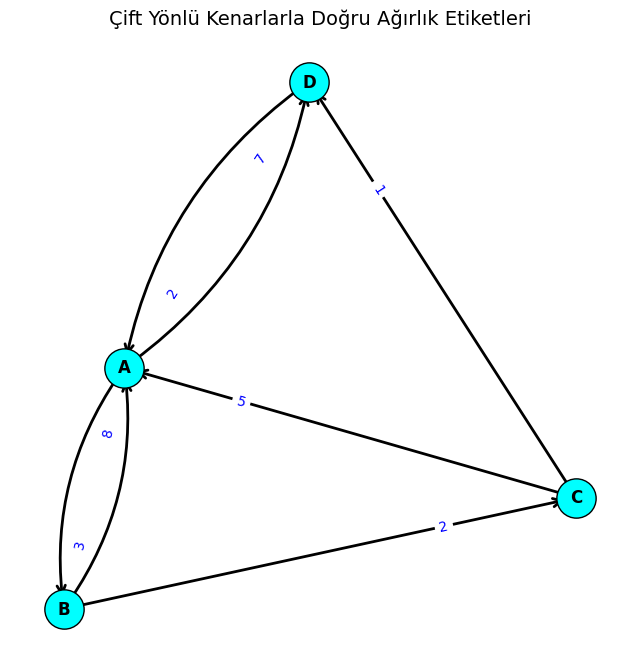

Düğüm Sayısı: 4

Kenarlar Tablosu:
  Kaynak Hedef  Ağırlık
0      A     B        3
1      A     D        7
2      B     A        8
3      B     C        2
4      D     A        2
5      C     A        5
6      C     D        1

Adım 1 (k=0):
   A    B    C    D    
A  0.0  3.0  inf 7.0  
B  8.0  0.0  2.0  inf 
C  5.0  inf 0.0  1.0  
D  2.0  inf inf 0.0  
---------------------------------------

Adım 2 (k=1):
   A    B    C    D    
A  0.0  3.0  inf 7.0  
B  8.0  0.0  2.0  15.0 
C  5.0  8.0  0.0  1.0  
D  2.0  5.0  inf 0.0  
---------------------------------------

Adım 3 (k=2):
   A    B    C    D    
A  0.0  3.0  5.0  7.0  
B  8.0  0.0  2.0  15.0 
C  5.0  8.0  0.0  1.0  
D  2.0  5.0  7.0  0.0  
---------------------------------------

Adım 4 (k=3):
   A    B    C    D    
A  0.0  3.0  5.0  6.0  
B  7.0  0.0  2.0  3.0  
C  5.0  8.0  0.0  1.0  
D  2.0  5.0  7.0  0.0  
---------------------------------------

Sonuç Mesafe Matrisi:
   A    B    C    D    
A  0.0  3.0  5.0  6.0  
B  5.0  0

In [39]:
def main():
    """Ana program fonksiyonu."""
    # Kullanıcıdan grafiği al
    G = get_graph_from_user()  # Kullanıcıdan kaynak, hedef ve ağırlık bilgilerini alarak grafiği oluşturuyoruz.

    # Grafik çizimi
    plot_graph(G)  # Kullanıcının oluşturduğu grafiği çiziyoruz.

    # Kenarlar tablosu
    edge_df = generate_edge_table(G)  # Grafikteki kenarları ve ağırlıkları tablo şeklinde bir pandas DataFrame'e dönüştürüyoruz.

    # Düğüm sayısını yazdır
    num_nodes = len(G.nodes())  # Grafikteki düğüm sayısını hesaplıyoruz.
    print(f"Düğüm Sayısı: {num_nodes}")  # Düğüm sayısını ekrana yazdırıyoruz.

    # Kenarları yazdır
    print("\nKenarlar Tablosu:")  # Kenarlar tablosunun başlık kısmını yazdırıyoruz.
    print(edge_df)  # Grafikteki kenarları ve ağırlıkları içeren tabloyu yazdırıyoruz.

    # edge_df'yi floyd_warshall fonksiyonuna uygun formata çevir
    edges = edge_df[['Kaynak', 'Hedef', 'Ağırlık']].values.tolist()  # Tabloyu, Floyd-Warshall algoritmasının alacağı formatta listeye çeviriyoruz.

    # Floyd-Warshall algoritmasını çalıştır
    floyd_warshall(edges)  # Elde edilen kenar listesini Floyd-Warshall algoritmasına vererek en kısa yolları hesaplıyoruz.

# Eğer bu dosya çalıştırıldığında main fonksiyonu çağrılacaksa
if __name__ == "__main__":
    main()  # main fonksiyonunu çağırıyoruz

